In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import nltk

Using TensorFlow backend.


In [2]:
df=pd.read_csv("Fake NEWS Dataset/train.csv")
df=df.iloc[:, 1:]
df.head()

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
df.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [4]:
df.dropna(axis=0, inplace=True)
df.shape

(18285, 4)

In [5]:
X=df.drop('label', axis=1)
y=df.label
X.shape, y.shape

((18285, 3), (18285,))

In [6]:
y.value_counts()

0    10361
1     7924
Name: label, dtype: int64

In [7]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, LSTM, Bidirectional
from keras.models import Sequential

In [8]:
vocab_size=10000
messages=X.copy()
messages.shape

(18285, 3)

In [9]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [10]:
messages.reset_index(inplace=True)
messages=messages.iloc[:, 1:]
messages.head(10)

,title,author,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...
5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi..."
6,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi..."
7,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...
8,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that..."
9,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...


In [11]:
messages['title'][50:55]

50    The Major Potential Impact of a Corporate Tax ...
51    I wonder what GLP will be like the day after t...
52    3 Makers of World’s Smallest Machines Awarded ...
53    Massive Anti-Trump Protests, Union Square NYC ...
54    Review: ‘Lion’ Brings Tears for a Lost Boy, Wi...
Name: title, dtype: object

In [12]:
import re
from nltk.corpus import stopwords

In [13]:
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()
corpus=[]

for i in range(0, len(messages)):
    
    review=re.sub("[^a-zA-Z]", ' ', messages['title'][i])
    review=review.lower().split()
    review=[ps.stem(word) for word in review if not word in stopwords.words("english")]
    review =" ".join(review)
    corpus.append(review)

In [14]:
corpus[0:10]

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart',
 'beno hamon win french socialist parti presidenti nomin new york time',
 'back channel plan ukrain russia courtesi trump associ new york time',
 'obama organ action partner soro link indivis disrupt trump agenda',
 'bbc comedi sketch real housew isi caus outrag']

## One-Hot Representation

In [15]:
one_hot_repr=[one_hot(words, vocab_size) for words in corpus]
one_hot_repr[:10]

[[4716, 3292, 8992, 2142, 6113, 9604, 5511, 4694, 8171, 2513],
 [5787, 5197, 6886, 9100, 195, 4712, 680],
 [3417, 3948, 6487, 7045],
 [621, 2780, 5097, 1755, 7359, 2302],
 [8732, 195, 2533, 1501, 8732, 5707, 195, 3747, 3202, 6027],
 [8775,
  3754,
  4834,
  2488,
  2394,
  4551,
  3976,
  8055,
  4441,
  853,
  8954,
  4249,
  2982,
  7728,
  680],
 [9202, 1225, 755, 282, 3668, 1405, 8862, 4659, 4442, 6010, 9477],
 [6309, 9752, 2763, 4414, 5947, 1779, 4551, 3935, 4442, 6010, 9477],
 [3146, 2334, 349, 2870, 2828, 9694, 458, 5608, 4551, 1506],
 [481, 32, 9077, 9255, 574, 2575, 5681, 3350]]

In [16]:
len(one_hot_repr)

18285

## Embedded Representation

In [17]:
sent_length=20
embedded_docs=pad_sequences(one_hot_repr, padding='pre', maxlen=sent_length)
embedded_docs[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 4716,
        3292, 8992, 2142, 6113, 9604, 5511, 4694, 8171, 2513],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 5787, 5197, 6886, 9100,  195, 4712,  680]])

In [18]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=256, input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(keras.layers.Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001), metrics=[
    keras.metrics.MeanSquaredError(name='mse'),
    keras.metrics.AUC(name='auc'),
    'accuracy'
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 256)           2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               285600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 2,845,801
Trainable params: 2,845,801
Non-trainable params: 0
_________________________________________________________________


In [19]:
X_final, y_final=np.array(embedded_docs), np.array(y)

In [20]:
print(X_final.shape, y_final.shape)

(18285, 20) (18285,)


In [21]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test=tts(X_final, y_final, test_size=0.1, random_state=100)

In [22]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100)

F:\Anaconda\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16456 samples, validate on 1829 samples
Epoch 1/10
16456/16456 [==============================] - 39s 2ms/step - loss: 0.2659 - mse: 0.0846 - auc: 0.9554 - accuracy: 0.8821 - val_loss: 0.1822 - val_mse: 0.0550 - val_auc: 0.9776 - val_accuracy: 0.9273
Epoch 2/10
16456/16456 [==============================] - 32s 2ms/step - loss: 0.1110 - mse: 0.0320 - auc: 0.9913 - accuracy: 0.9562 - val_loss: 0.1918 - val_mse: 0.0576 - val_auc: 0.9768 - val_accuracy: 0.9229
Epoch 3/10
16456/16456 [==============================] - 32s 2ms/step - loss: 0.0687 - mse: 0.0189 - auc: 0.9965 - accuracy: 0.9753 - val_loss: 0.2083 - val_mse: 0.0600 - val_auc: 0.9747 - val_accuracy: 0.9229
Epoch 4/10
16456/16456 [==============================] - 31s 2ms/step - loss: 0.0416 - mse: 0.0108 - auc: 0.9984 - accuracy: 0.9864 - val_loss: 0.2569 - val_mse: 0.0670 - val_auc: 0.9722 - val_accuracy: 0.9163
Epoch 5/10
16456/16456 [==============================] - 34s 2ms/step - loss: 0.0230 - mse: 0.0060 - auc: 

In [26]:
y_pred=model.predict_classes(X_test)

In [24]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

F:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


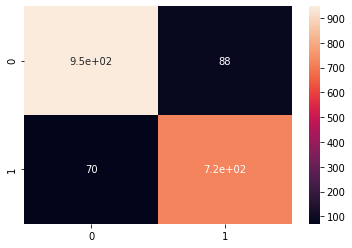

In [27]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [28]:
confusion_matrix(y_pred, y_test)

array([[947,  70],
       [ 88, 724]], dtype=int64)

In [29]:
accuracy_score(y_test, y_pred)

0.9136139967195188

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1035
           1       0.89      0.91      0.90       794

    accuracy                           0.91      1829
   macro avg       0.91      0.91      0.91      1829
weighted avg       0.91      0.91      0.91      1829

